In [1]:
from buffers import PostgreSQLReplayBuffer
from agents import ValueAgent
from models import ValueNetwork

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot(iteration, losses, values):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Iteration %s. Loss: %s.' % (iteration, losses[-1]))
    plt.plot(losses)
    plt.subplot(132)
    plt.title('Iteration %s. Mean V: %s.' % (iteration, values[-1]))
    plt.plot(values)
    plt.show()

In [4]:
replay_buffer = PostgreSQLReplayBuffer()
agent = ValueAgent(ValueNetwork, replay_buffer, batch_size=256, gamma=0.92, device="cuda", update=10)

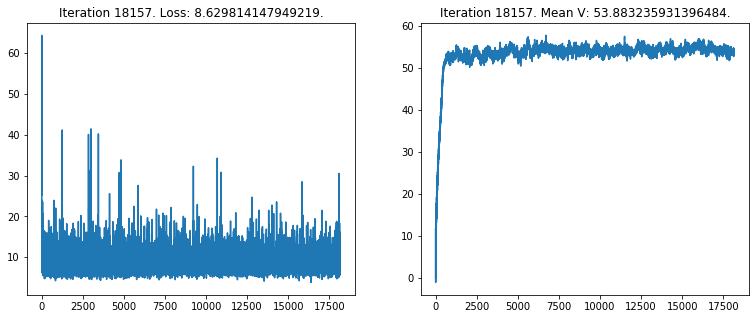

KeyboardInterrupt: 

In [5]:
losses = []
values = []
for iteration in range(100000):
    loss, mean_v = agent.train()
    losses.append(loss)
    values.append(mean_v)
    plot(iteration, losses, values)

In [7]:
agent.save("./model_bs256_g92_u10.pth")

In [1]:
import torch

In [2]:
model = torch.load("model_bs256_g92_u10.pth")

ValueNetwork(
  (linear1): Linear(in_features=6, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
)

# Train example with torch.Dataset

In [6]:
from agents import ValueAgentDataset
from models import ValueNetwork
from dataset import CSVDataset
from preprocess import simple_preprocess
import torch

In [10]:
# define dataset on csv-file
# It works like this:
# (1) loads csv file int pandas.Dataframe
# (2) applies 'preprocess_fn' on loaded DataFrame
# (3) maps columns in preprocessed dataset to state, next_state, reward, info, done 
dataset = CSVDataset(csv_file='SAMPLE_didi_calc_rides_and_repositions.csv',
                   root_dir='../data',
                   preprocess_fn = simple_preprocess,
                   state_cols=['pickup_weekday_sin', 'pickup_weekday_cos', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_lon', 'pickup_lat'],
                   next_state_cols=['dropoff_weekday_sin', 'dropoff_weekday_cos','dropoff_hour_sin', 'dropoff_hour_cos', 'dropoff_lon', 'dropoff_lat'],
                   reward_cols=['reward'],
                   info_cols=['info'],
                   done_cols=['done'])

In [14]:
# define ValueAgentDataset. It inherits behavior from ValueAgent but re-implements self.train() function
# inside ValueAgentDataset there is self.dataloader, which iterates over Dataset while learning.
# behavior of self.dataloader could be customized by passing it args to ValueAgentDataset constructor
# see https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader for details
# dataloaderr args (shuffle, drop_last, num_workers, pin_memory) are subject of most interest to play with

agent = ValueAgentDataset(dataset=dataset, 
                          value_net_class=ValueNetwork,
                          batch_size=32,
                          gamma=0.99,
                          device="cpu",
                          lr=1e-3,
                          hidden_dim=256,
                          update=10,
                          random_seed=1488,
                          #dataloader args below
                         shuffle=True,
                         drop_last=True)

In [15]:
NUM_EPOCHS = 10
torch.manual_seed(1488)

losses = []
means_v = []
stds_v = []

In [16]:
for epoch in range(NUM_EPOCHS):
    # you can change torch.manual_seed() here if you want different sampling on every new epoch
    while True:
        try:
            # train
            loss, mean_v, std_v = agent.train()
            
            losses.append(loss)
            means_v.append(mean_v)
            stds_v.append(std_v)
        
        # end of dataset iterator is reached
        except StopIteration:
            # reset iterator to continue learning on the same dataset
            agent.reset_iter()
            # next 
            break
    print('Epoch: %d\tloss: %.4f\tmean_v: %.4f\tstd_v: %.4f' % (epoch, loss, mean_v, std_v))

Epoch: 0	loss: 29.7535	mean_v: 156.1100	std_v: 0.1735
Epoch: 1	loss: 7.5642	mean_v: 216.9769	std_v: 0.2887
Epoch: 2	loss: 11.0714	mean_v: 220.3916	std_v: 0.3413
Epoch: 3	loss: 10.0804	mean_v: 236.8738	std_v: 0.3224
Epoch: 4	loss: 8.8689	mean_v: 228.1989	std_v: 0.3856
Epoch: 5	loss: 6.6399	mean_v: 243.0405	std_v: 0.4620
Epoch: 6	loss: 9.3827	mean_v: 247.8929	std_v: 0.5505
Epoch: 7	loss: 4.4823	mean_v: 244.3137	std_v: 0.5966
Epoch: 8	loss: 7.8245	mean_v: 251.0946	std_v: 0.6540
Epoch: 9	loss: 6.4788	mean_v: 250.4990	std_v: 0.6291
